In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import arviz as az
from sklearn.linear_model import QuantileRegressor
import pymc as pm
import pytensor
import pytensor.tensor as pt
from scipy import stats
import patsy

In [2]:
def negative_binomial(mu, alpha, size):
        g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
        return stats.poisson.rvs(g)

def generate_time_series(n_series, t_length, r=0.3, k=100):
    'Generate heteroscedastic time series for an inference problem'

    np.random.seed(1)
    
    # Generate a non-stationary time series corresponding to the local m

    
    # Seasonal componentst = np.arange(0,365*5)
    t = np.arange(0,365*5)
    weekly = np.sin(2*np.pi*t/7)**3 - 5*np.sin(2*np.pi*t/7)**2 + np.sin(2*np.pi*t/7)*0.5
    weekly = weekly - np.mean(weekly)
    monthly = 0.5*np.sin(2*np.pi*t/30 + 10)
    monthly = monthly - np.mean(monthly)
    yearly  = 0.5*np.sin(2*np.pi*t/365)
    yearly = yearly - np.mean(yearly)

    # Add marketing spend
    spend_bin = np.random.binomial(1,0.25, 365*5)
    spend = np.random.negative_binomial(1, 0.3, size=len(t))*np.exp(t/365)*spend_bin
    marketing_effect = 0.1*spend
    
    t_i = t
    t_i = t_i + weekly*0.01*t + yearly*0.1*t
    t_i = np.exp(t_i/365)

    y =  negative_binomial(t_i, t_i, size=t_length) + marketing_effect
   
    return y, spend



y, spend = generate_time_series(1, 365*5)


In [4]:
df = pd.concat([pd.Series(y), pd.Series(spend)], axis=1)
df = df.set_axis(["Sales", "Spend"], axis=1)
df.assign(t = np.arange(0,df.shape[0]))
df.assign(year = np.tile(np.arange(0,365), 5))

# Add a week variable
rep = int(df.shape[0]/7)
week = np.tile(np.arange(0,7), rep)
week = np.append(week, [0,1,2,3,4])
df.assign(week = week)




SyntaxError: invalid syntax (3662688422.py, line 4)

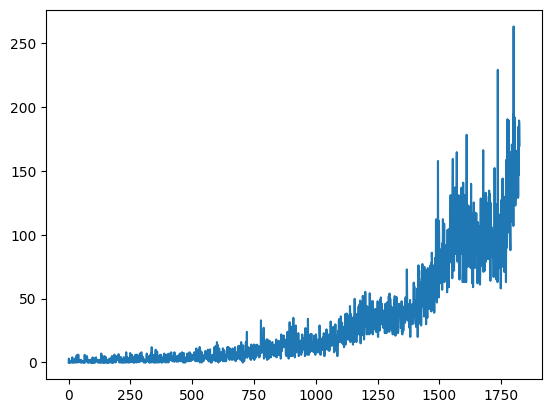

In [4]:
plt.plot(df['Sales'])
plt.show()

Spline Model in PyMC with Conditional Variance

In [5]:
df.shape[0]
df.head()


,Sales,Spend,t,year,week
0,0.0,0.0,0,0,0
1,3.0,0.0,1,1,1
2,0.0,0.0,2,2,2
3,2.0,0.0,3,3,3
4,1.0,0.0,4,4,4


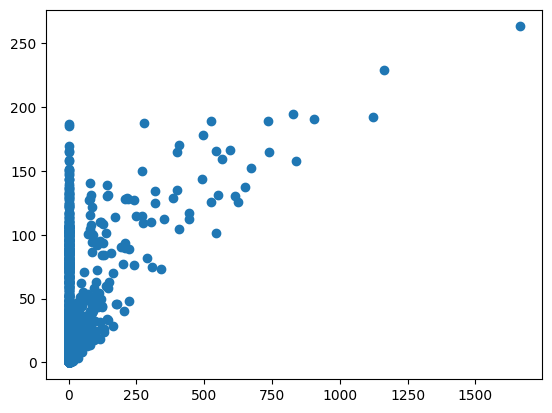

In [6]:
plt.scatter(df['Spend'], df['Sales'])

In [7]:
X = df.loc[:,['t','Spend']]
# Create the spline basis for the model with cubic spline basis
B = patsy.dmatrix("cr(time, df=6) - 1", {"time": df['t']})

# Define a cyclical spline basis
S = patsy.dmatrix("cc(year, df=6)", {"year": df['year']})

Week = patsy.dmatrix("cc(week, df=6)", {"year": df['week']})

# Specify the dimensions for the model
dims = {"obs": np.arange(0,X.shape[1]), "splines": np.arange(B.shape[1]), "seasonality": np.arange(S.shape[1]), "weekly": np.arange(Week.shape[1])}

print(dims['obs'])

# Create and train the bayesian model
with pm.Model(coords=dims) as model:

    # Define the distribution mean

    # Create a weight matrix for the trend
    w = pm.Normal("w", mu=0, sigma=10, dims="splines")

    # Create a weight matrix for the seasonality spline
    w_s = pm.Normal("w_s", mu=0, sigma=1, dims="seasonality")

    # Weekly Seasonality Weights
    w_weekly = pm.Normal("w_weekly", mu=0, sigma=1, dims="weekly")

    # Create a linear term for the marketing spend
    beta = pm.Normal("beta", mu=0, sigma=5)

    z = pm.math.dot(np.asarray(B, order="F"), w.T)
    z2 = pm.math.dot(np.asarray(S, order="F"), w_s.T)
    z_weekly = pm.math.dot(np.asarray(S, order="F"), w_weekly.T)
    mu = pm.Deterministic("mu", np.exp(z*(1 + z2 + z_weekly)) + beta*X['Spend'])
    
    # Define the dispersion
    w_v = pm.Normal("w_v", mu=0, sigma=1, dims="splines")
    w_sv = pm.Normal("w_sv", mu=0, sigma=1, dims="seasonality")
    w_weekly_v = pm.Normal("w_weekly_v", mu=0, sigma=1, dims="weekly")
    z3 = pm.math.dot(np.asarray(B, order="F"), w_v.T)
    z4 = pm.math.dot(np.asarray(S, order="F"), w_sv.T)
    z_weekly_v = pm.math.dot(np.asarray(S, order="F"), w_weekly_v.T)
    sigma_cv = pm.Deterministic('sigma_cv', np.exp(z3*(1+z4 + z_weekly_v)))

    # Define the likelihood function (negative binomial)
    likelihood = pm.NegativeBinomial("y", mu=mu, alpha=sigma_cv, observed=df['Sales'])


[0 1]


In [8]:
with model:
    # inference∂
    trace = pm.sample(1000, tune=500, cores=1, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, w_s, w_weekly, beta, w_v, w_sv, w_weekly_v]


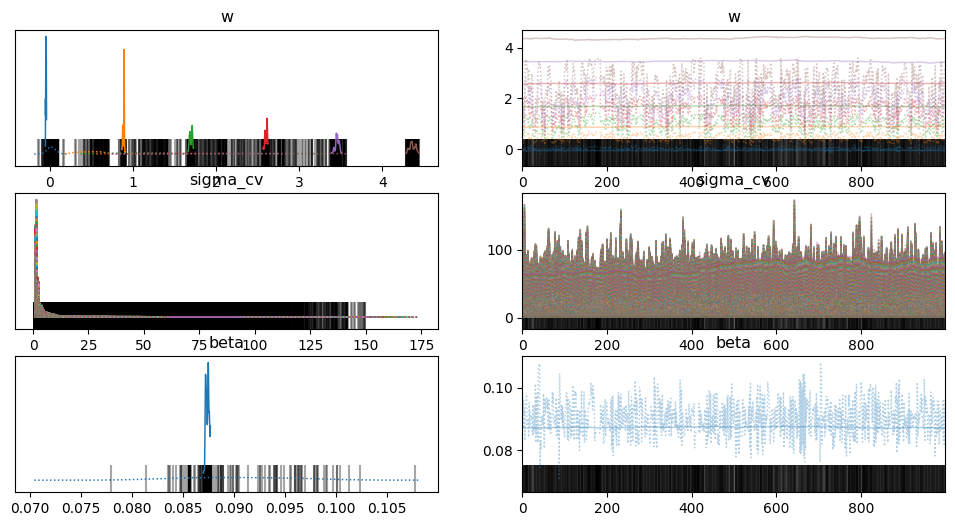

In [73]:
az.plot_trace(trace, var_names=["w", "sigma_cv","beta"]);

In [82]:
# Get the posterior and calculate the mean
with model:
    post_y = pm.sample_posterior_predictive(trace, var_names=["y"])

post_y = post_y.posterior_predictive['y']
post_y = np.mean(post_y[:,:,:], axis=0)
post_y.shape

# Extract the quantiles from the posterior
post_quantiles = np.quantile(post_y, q = [0.01, 0.5, 0.99], axis=0)

# Add to the plotting frame
plot_df = df.reset_index(drop=True)
plot_df["pred_mean"] = post_quantiles[1,:]
plot_df["pred_lower"] = post_quantiles[0,:]
plot_df["pred_upper"] = post_quantiles[2,:]

Sampling: [y]


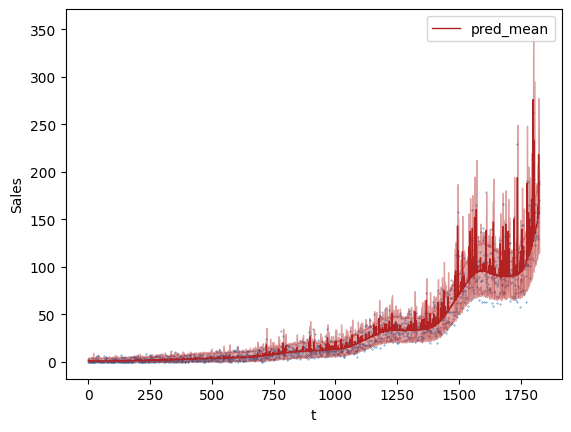

In [83]:
df.plot.scatter("t","Sales",size=0.1) 
plot_df.plot("t", "pred_mean", ax=plt.gca(), lw=1, color="firebrick")
plt.fill_between(
    plot_df.t,
    plot_df.pred_lower,
    plot_df.pred_upper,
    color="firebrick",
    alpha=0.4,
)

In [85]:

beta_fit = az.summary(trace, var_names=['beta'])
beta_fit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.089,0.004,0.082,0.099,0.001,0.001,47.0,100.0,1.74


In [106]:
# Plot the Weekly seasonality
w_weekly = trace.posterior["w_weekly"].values.mean(axis=(0, 1))

spline_df = (
    pd.DataFrame(Week * w_weekly.T)
    .assign(time=df['t'])
)

plt.plot(np.mean(Week*w_weekly.T, axis=1)[:28])


ValueError: operands could not be broadcast together with shapes (1825,4) (7,) 